### Train a 1D CNN model to classify the synthetic ECG data and test the model on real data 

In [1]:
from synDataLoader import syn_mitbih, mixed_mitbih
from DataLoader import mitbih_train, mitbih_test

In [2]:
from main_torch import CNNLSTMModel

In [21]:
mixed_ecg = mixed_mitbih(real_samples = 1000, syn_samples = 4000)

data shape is (20000, 1, 187)
labels shape is (20000,)
The dataset including 4000 class 0, 4000 class 1, 4000 class 2, 4000 class 3, 4000 class 4
X_train shape is (5000, 1, 187)
y_train shape is (5000,)
The dataset including 1000 class 0, 1000 class 1, 1000 class 2, 1000 class 3, 1000 class 4
data shape is (25000, 1, 187)
labels shape is (25000,)


In [4]:
syn_ecg = syn_mitbih(n_samples=400, reshape=True)

data shape is (2000, 1, 187)
labels shape is (2000,)
The dataset including 400 class 0, 400 class 1, 400 class 2, 400 class 3, 400 class 4


In [5]:
real_ecg = mitbih_train(n_samples=1000, oneD=True)

X_train shape is (5000, 1, 187)
y_train shape is (5000,)
The dataset including 1000 class 0, 1000 class 1, 1000 class 2, 1000 class 3, 1000 class 4


In [22]:
real_test_ecg = mitbih_test(n_samples=1000, oneD=True)

X_test shape is (5000, 1, 187)
y_test shape is (5000,)
The dataset including 15003 class 0, 1614 class 1, 1451 class 2, 509 class 3, 1426 class 4


In [7]:
from torch.utils import data
syn_loader = data.DataLoader(syn_ecg, batch_size=32, num_workers=4, shuffle=True)
real_loader = data.DataLoader(real_ecg, batch_size=32, num_workers=4, shuffle=True)
mixed_loader = data.DataLoader(mixed_ecg, batch_size=32, num_workers=4, shuffle=True)
test_real_loader = data.DataLoader(real_test_ecg, batch_size=32, num_workers=4, shuffle=True)

In [30]:
#Define a simple CNN classifier 
import torch
import torch.nn as nn
import torch.nn.functional as F


class ECG_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 6)
        self.conv2 = nn.Conv1d(64, 64, 6)
        self.conv3 = nn.Conv1d(64, 64, 3)
        self.dropout = nn.Dropout(p=0.5) 
        self.pool = nn.MaxPool1d(3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [23]:
def train(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, filename="test_cm"):
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()
        total_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(train_data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = total_loss / len(train_data_loader)
        epoch_train_acc = correct / total
        print(f'Epoch {epoch + 1}, train loss = {epoch_train_loss}, train acc = {epoch_train_acc}')

        if (epoch+1) % 5 == 0:
            _eval(model, test_data_loader, criterion, epoch)
#             _eval_single_class(model, test_data_loader, criterion, epoch)
            
    _final_eval(model, test_data_loader, criterion, filename)

    print('Finished Training and testing')

In [24]:
def _eval(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_test_loss = total_loss / len(real_test_loader)
        epoch_test_acc = correct / total
    
    print('=====================================================')
    print(f'Epoch {epoch+1}, test loss = {epoch_test_loss}, test acc = {epoch_test_acc}')
    print('=====================================================')

In [25]:
classes = ['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats', 'Unknown', 'Fusion Beats']
classes_idx = ['1','2','3','4','5']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [26]:
def _eval_single_class(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def _final_eval(model, real_test_loader, criterion, filename="test_cm"):
    nb_classes = 5
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    target_names = classes
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,predictions.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
            
            y_preds.append(predictions)
            y_trues.append(labels)
            
    # Confusion matrix
    cm=confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(cm)
    cm_df = pd.DataFrame(cm,
                     index = classes_idx, 
                     columns = classes_idx)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#     plt.title('ECG classification Accuracy')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.savefig(f'{filename}.pdf')
    plt.show()
    
    # Per-class accuracy
    class_accuracy = 100*cm.diagonal() / cm.sum(1)
    print(class_accuracy)
    
    #print classification report 
    y_preds_flatten = [label for sublist in y_preds for label in sublist]
    y_trues_flatten = [label for sublist in y_trues for label in sublist]
    
    print(classification_report(y_trues_flatten, y_preds_flatten, target_names=classes))

In [28]:
import os
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.nn.parameter import Parameter
from sklearn.metrics import accuracy_score
from tqdm import tqdm

Epoch 1, train loss = 1.610037201294996, train acc = 0.2085
Epoch 2, train loss = 1.6101285431822523, train acc = 0.2035


Epoch 3, train loss = 1.6099892738640789, train acc = 0.198
Epoch 4, train loss = 1.6106890038200938, train acc = 0.189
Epoch 5, train loss = 1.6097417193996362, train acc = 0.197
Epoch 5, test loss = 1.6096001402192994, test acc = 0.2
Epoch 6, train loss = 1.6100208552823791, train acc = 0.187
Epoch 7, train loss = 1.6094655039232564, train acc = 0.1965
Epoch 8, train loss = 1.6096601698115998, train acc = 0.1945
Epoch 9, train loss = 1.6088138428439276, train acc = 0.2165
Epoch 10, train loss = 1.6093670074388822, train acc = 0.1965
Epoch 10, test loss = 1.6090315864366274, test acc = 0.2
Epoch 11, train loss = 1.609273008764096, train acc = 0.2085
Epoch 12, train loss = 1.6089667692521579, train acc = 0.207
Epoch 13, train loss = 1.6086773101563172, train acc = 0.209
Epoch 14, train loss = 1.6089045907140633, train acc = 0.2085
Epoch 15, train loss = 1.607627641394799, train acc = 0.2285
Epoch 15, test loss = 1.6086052235035435, test acc = 0.2
Epoch 16, train loss = 1.60888625402796

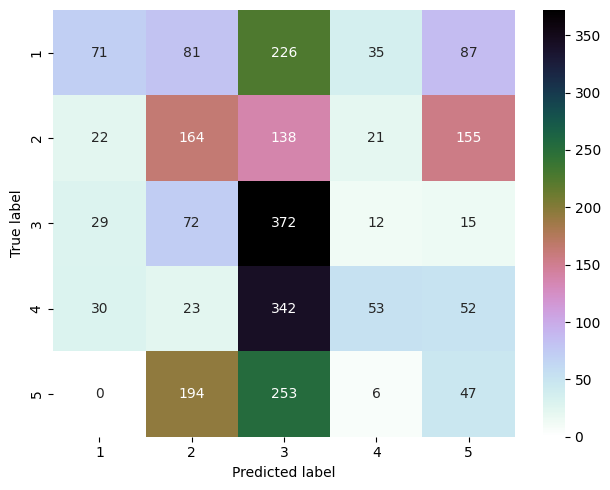

[14.2 32.8 74.4 10.6  9.4]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.47      0.14      0.22       500
Superventrical Ectopic       0.31      0.33      0.32       500
     Ventricular Beats       0.28      0.74      0.41       500
               Unknown       0.42      0.11      0.17       500
          Fusion Beats       0.13      0.09      0.11       500

              accuracy                           0.28      2500
             macro avg       0.32      0.28      0.24      2500
          weighted avg       0.32      0.28      0.24      2500

Finished Training and testing


In [17]:
# Define training hyperparameters
import torch.optim as optim
ECG_model = CNNLSTMModel()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, syn_loader, test_real_loader, 50, criterion, optimizer, filename='synthetic_data')

Epoch 1, train loss = 1.6121734599297206, train acc = 0.202
Epoch 2, train loss = 1.6108001940090262, train acc = 0.1984
Epoch 3, train loss = 1.610391994581923, train acc = 0.2012
Epoch 4, train loss = 1.609682353691391, train acc = 0.2074
Epoch 5, train loss = 1.6099581933274945, train acc = 0.2008
Epoch 5, test loss = 1.6093455847109237, test acc = 0.2
Epoch 6, train loss = 1.6097162610738802, train acc = 0.2034
Epoch 7, train loss = 1.60896421290599, train acc = 0.2062
Epoch 8, train loss = 1.609180468022976, train acc = 0.2094
Epoch 9, train loss = 1.6093041439138787, train acc = 0.2038
Epoch 10, train loss = 1.6087430919710874, train acc = 0.2152
Epoch 10, test loss = 1.6087701615183538, test acc = 0.2612
Epoch 11, train loss = 1.6090277147535008, train acc = 0.2118
Epoch 12, train loss = 1.6087349828916897, train acc = 0.2222
Epoch 13, train loss = 1.608829604894374, train acc = 0.2198
Epoch 14, train loss = 1.6085482760912937, train acc = 0.2156
Epoch 15, train loss = 1.6085653

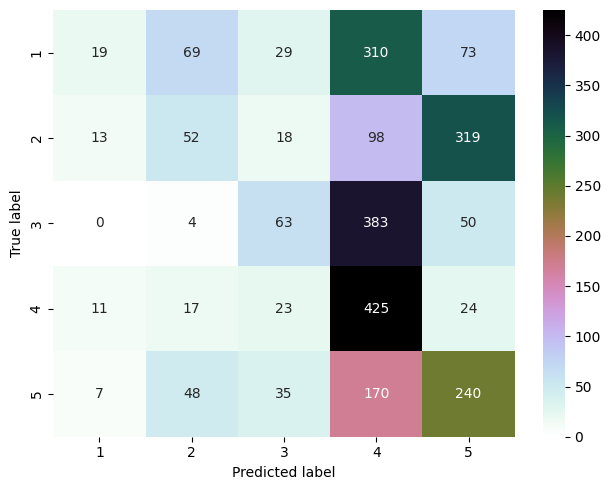

[ 3.8 10.4 12.6 85.  48. ]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.38      0.04      0.07       500
Superventrical Ectopic       0.27      0.10      0.15       500
     Ventricular Beats       0.38      0.13      0.19       500
               Unknown       0.31      0.85      0.45       500
          Fusion Beats       0.34      0.48      0.40       500

              accuracy                           0.32      2500
             macro avg       0.34      0.32      0.25      2500
          weighted avg       0.34      0.32      0.25      2500

Finished Training and testing


In [19]:
# Define training hyperparameters
import torch.optim as optim
ECG_model = CNNLSTMModel()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, real_loader, test_real_loader, 30, criterion, optimizer, filename='real_data')

Epoch 1, train loss = 1.5814330717591014, train acc = 0.4024
Epoch 2, train loss = 1.4585826100719246, train acc = 0.584
Epoch 3, train loss = 1.1239665608866969, train acc = 0.6668
Epoch 4, train loss = 0.7841169974435332, train acc = 0.7836
Epoch 5, train loss = 0.5993914336677352, train acc = 0.85
Epoch 5, test loss = 1.0597550817412034, test acc = 0.6756
Epoch 6, train loss = 0.49805537358454655, train acc = 0.8704
Epoch 7, train loss = 0.4204245293252599, train acc = 0.9008
Epoch 8, train loss = 0.37001130851142183, train acc = 0.9108
Epoch 9, train loss = 0.3429959246260172, train acc = 0.9152
Epoch 10, train loss = 0.3224138628301249, train acc = 0.9192
Epoch 10, test loss = 0.7962201912624791, test acc = 0.72
Epoch 11, train loss = 0.2915033293238698, train acc = 0.9272
Epoch 12, train loss = 0.2825278351474832, train acc = 0.9288
Epoch 13, train loss = 0.26833993750350765, train acc = 0.9324
Epoch 14, train loss = 0.2641316925508864, train acc = 0.9336
Epoch 15, train loss = 0

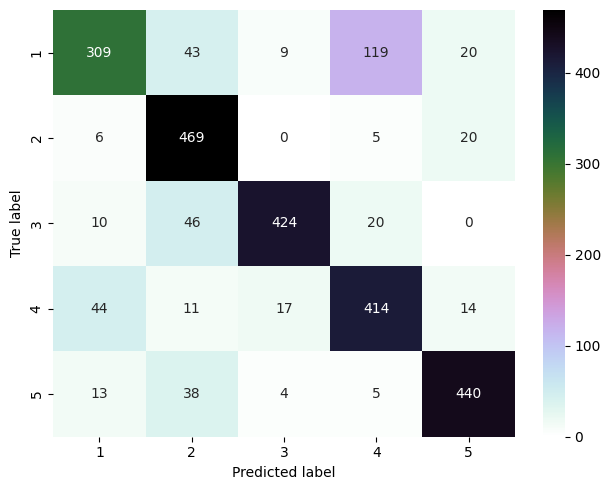

[61.8 93.8 84.8 82.8 88. ]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.81      0.62      0.70       500
Superventrical Ectopic       0.77      0.94      0.85       500
     Ventricular Beats       0.93      0.85      0.89       500
               Unknown       0.74      0.83      0.78       500
          Fusion Beats       0.89      0.88      0.89       500

              accuracy                           0.82      2500
             macro avg       0.83      0.82      0.82      2500
          weighted avg       0.83      0.82      0.82      2500

Finished Training and testing


In [31]:
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, mixed_loader, test_real_loader, 50, criterion, optimizer, filename='mixed_data')